In this notebook I'll be extending the library to handle discrete domains and fixed candidate sets (as opposed to analytic, continuous functions). To do so, I'll create an `Oracle` class which can be inherited to create `AnalyticOracle` or `FixedOracle` classes. I'll also need to update the `BOLoop` class to track which candidates have been observed in the case where we have a fixed candidate pool.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sns.set_style("whitegrid")
sns.set_palette("muted")

In [2]:
from molbo.acquisition import LogEIAcquisition
from molbo.bo import BOLoop
from molbo.models import GPModel, TanimotoGPModel
from molbo.oracles import AnalyticOracle, LookupOracle
from molbo.utils import plot_1d_interactive, smiles_to_morgan_fp

# Optimizing an analytic oracle in 1D

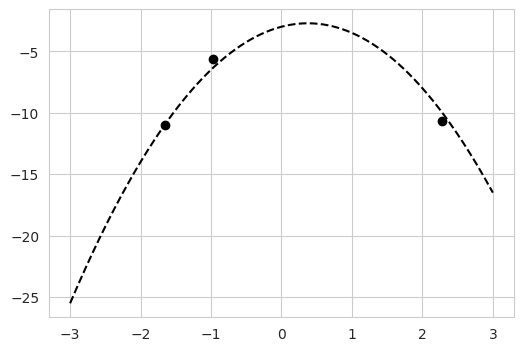

In [ ]:
def f(X):
    return - 2 * X**2 + 1.5 * X - 3

bounds = torch.tensor([-3.0, 3.0]).unsqueeze(-1)

oracle = AnalyticOracle(
    f=f,
    bounds=bounds,
    noise_std=1.0,
    optimal_value=-2.71875
)

xs = torch.linspace(-3.0, 3.0, 1000)
y = f(xs)

bounds = oracle.bounds

# Generate 3 random samples
n_init = 3
train_X = bounds[0].item() + (torch.rand(n_init, 1, dtype=torch.float64) * bounds.diff(dim=0).item())
train_y = oracle(train_X)

plt.figure(figsize=(6,4))
plt.plot(xs, y, c='k', ls='--', zorder=1)
plt.scatter(train_X, train_y, c='k')

In [4]:
model = GPModel(train_X, train_y)
acq_func = LogEIAcquisition(model)
bo_loop = BOLoop(model, acq_func, oracle)
history = bo_loop.run(n_iters=3)

plot_1d_interactive(bo_loop)

# Optimizing a fixed candidate pool

In [5]:
import polaris as po

# Load dataset from Polaris
dataset = po.load_dataset("asap-discovery/antiviral-potency-2025-unblinded")

Output()

[2026-02-16 16:47:05] INFO     The version of Polaris that was used to create the artifact          ]8;id=561747;file:///home/wvir/miniconda3/envs/molbo/lib/python3.11/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=635568;file:///home/wvir/miniconda3/envs/molbo/lib/python3.11/site-packages/polaris/_artifact.py#96\96]8;;\
                               (0.11.8.dev4+g40e3b2b.d20250207) is different from the currently                    
                               installed version of Polaris (0.13.0).                                              

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=298106;file:///home/wvir/miniconda3/envs/molbo/lib/python3.11/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=291223;file:///home/wvir/miniconda3/envs/molbo/lib/python3.11/site-packages/polaris/dataset/_base.py#187\187]8;;\
                               enough, consider caching the dataset first using DatasetV2.cache() for              
                               more performant data access.                                                        

[16:47:05]  Success: Fetching dataset                                                                 ]8;id=301085;file:///home/wvir/miniconda3/envs/molbo/lib/python3.11/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=125422;file:///home/wvir/miniconda3/envs/molbo/lib/python3.11/site-packages/polaris/utils/context.py#53\53]8;;\

In [14]:
smiles_list, y_data =  dataset[0:100]['CXSMILES'], torch.from_numpy(dataset[0:100]['pIC50 (MERS-CoV Mpro)']).unsqueeze(-1)
X_data = torch.vstack([smiles_to_morgan_fp(s) for s in smiles_list])

oracle = LookupOracle(X_data, y_data, noise_std=0.5)

train_indices = torch.randint(0, 100, (3,))
train_X = X_data[train_indices]
train_y = oracle(train_X)

In [15]:
model = TanimotoGPModel(train_X, train_y)
acq_func = LogEIAcquisition(model)
bo_loop = BOLoop(model, acq_func, oracle, candidates=X_data)
history = bo_loop.run(50)

In [16]:
history['X_observed'].unique(dim=0).shape, history['y_observed'].unique().shape

(torch.Size([50, 2048]), torch.Size([50]))

In [17]:
history['y_observed'].max(), y_data.max()

(tensor(8.1992, dtype=torch.float64), tensor(8.1600, dtype=torch.float64))